In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase

# SimPEG/ discretize
import discretize
from discretize import utils
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
path_to_data = "/t40array/lheagy/casing-permeability"
directory = "fields_halfspace"

In [5]:
sigma_air = 1e-4
sigma_back = np.r_[1e-1, 0.5, 1]

In [6]:
cs = 10
src_a = np.r_[-55, 0, -cs/2]
src_b = np.r_[55, 0, -cs/2]

In [7]:
nt = 30
time_steps = [
    (1e-6, nt), (3e-6, nt), 
    (1e-5, nt), (3e-5, nt), 
    (1e-4, nt), (3e-4, nt), 
    (1e-3, nt*2), (3e-3, nt*2),
    (6e-3, nt*3), (1e-2, nt),
]

time_steps = discretize.utils.unpack_widths(time_steps)
times = np.cumsum(np.hstack([np.r_[0], time_steps]))
print(times.max())

print(f"diffusion distance {np.sqrt(2*np.max(times)/(mu_0*sigma_back))} m")

1.0933200000000007
diffusion distance [4171.41801174 1865.51484736 1319.11819897] m


In [8]:
nc = 12
npad = 13
pf = 1.5
hx = [(cs, npad, -pf), (cs, nc), (cs, npad, pf)]
hy = [(cs, npad, -pf), (cs, nc-1), (cs, npad, pf)]
hz = hx

mesh = discretize.TensorMesh([hx, hy, hz], "CCC")
mesh

TensorMesh: 53,428 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     38     -5,868.59      5,868.59     10.00  1,946.20    1.50
   y     37     -5,863.59      5,863.59     10.00  1,946.20    1.50
   z     38     -5,868.59      5,868.59     10.00  1,946.20    1.50

In [9]:
conductivity_model = sigma_air * np.ones(mesh.n_cells)
inds_subsurface = mesh.cell_centers[:, 2] < 0

conductivity_models = {}

for s in sigma_back:
    tmp = conductivity_model.copy()
    tmp[inds_subsurface] = s
    conductivity_models[s] = tmp

In [10]:
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, cs*1.5], src_b+np.r_[0, 0, cs*1.5], src_b
    ]
)

In [11]:
src = tdem.sources.LineCurrent([], location=src_locations)
survey = tdem.Survey([src])
simj = tdem.simulation.Simulation3DCurrentDensity(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, time_steps=time_steps, 
)

simh = tdem.simulation.Simulation3DMagneticField(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, time_steps=time_steps, 
)


In [12]:
fieldsj = {}
fieldsh = {}

mesh.save(f"{path_to_data}/{directory}/mesh.json")
np.save(f"{path_to_data}/{directory}/times", simj.times)

for key in sigma_back: 
    t = time.time()
    print(f"starting {key:1.0e}")
    
    fieldsj[key] = simj.fields(conductivity_models[key])
    np.save(f"{path_to_data}/{directory}/fieldsj_{key}", fieldsj[key][:, "jSolution", :])
    
    fieldsh[key] = simh.fields(conductivity_models[key])
    np.save(f"{path_to_data}/{directory}/fieldsh_{key}", fieldsh[key][:, "hSolution", :])
    
    print(f" ... done. {time.time()-t:1.2e} s")

starting 1e-01


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.edgeCurl has been deprecated, please use TensorMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vol has been deprecated, please use TensorMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.faceDiv has been deprecated, please use TensorMesh.face_divergence. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1042: FutureWarning: hy has bee

 ... done. 1.86e+02 s
starting 5e-01
 ... done. 1.93e+02 s
starting 1e+00
 ... done. 1.90e+02 s


In [13]:
time_inds = [
    0,
#     1, 
#     3, 
#     10, 
#     30, 
    53, 
    # 78, 
    109,
    # 137,
    152,
    169,
    197,
    # 207,
    # 212,
    # 227,
    249,
] 
print(times[time_inds] * 1e3)

[0.0000e+00 9.9000e-02 9.9000e-01 4.9200e+00 1.0020e+01 3.0320e+01
 1.0032e+02]


In [14]:
def get_grid_loc(fieldtype):
    return "E" if fieldtype in ["h", "b", "dhdt", "dbdt"] else "F" 

In [23]:
def get_fields_components(fieldsobject, key, fieldtype):
    grid_loc = get_grid_loc(fieldtype)
    n_per_direction = mesh.n_edges_per_direction if fieldtype in ["h", "b", "dhdt", "dbdt"] else mesh.n_faces_per_direction
    
    fieldplot = fieldsobject[key][:, fieldtype, ti]
    fieldxplot = fieldplot[:n_per_direction[0]]
    fieldyplot = fieldplot[n_per_direction[0]:sum(n_per_direction[:2])]
    fieldzplot = fieldplot[sum(n_per_direction[:2]):]
    
    return discretize.utils.mkvc(fieldxplot), discretize.utils.mkvc(fieldyplot), discretize.utils.mkvc(fieldzplot)
    

In [38]:
# view h for two models at time ti
ti = time_inds[0]

def plot_field_time(ti=0, fieldtype="h", fieldsobject=fieldsh, fieldsobject2=None, view="total", clim=None, ind=19, xlim=(src_b[0] + 5*cs)*np.r_[-1, 1]):
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,8))   
    grid_loc = get_grid_loc(fieldtype)
    eps = 1e-10
    
    for j, key in enumerate(sigma_back): 
        plotx, ploty, plotz = get_fields_components(fieldsobject, key, fieldtype)
        
        if view in ["difference", "percent"]:
            fieldsxplot2, fieldsyplot2, fieldszplot2 = get_fields_components(fieldsobject2, key, fieldtype)
            plotx = plotx - fieldsxplot2
            ploty = ploty - fieldsyplot2
            plotz = plotz - fieldszplot2
            if view == "percent":
                plotx = plotx / (np.abs(fieldsxplot2) + eps) * 100
                ploty = ploty / (np.abs(fieldsyplot2) + eps) * 100
                plotz = plotz / (np.abs(fieldszplot2) + eps) * 100
        
        if clim is None: 
            vmin = np.min(np.hstack([plotx, ploty, plotz]))
            vmax = np.max(np.hstack([plotx, ploty, plotz]))
            pcolor_opts = {"norm":Normalize(vmin=vmin, vmax=vmax)}
        else: 
            pcolor_opts = {"norm":Normalize(vmin=clim.min(), vmax=clim.max())}

        mesh.plot_slice(plotx, f"{grid_loc}x", normal="z", ax=ax[j, 0], ind=ind, pcolor_opts=pcolor_opts)
        mesh.plot_slice(ploty, f"{grid_loc}y", normal="z", ax=ax[j, 1], ind=ind, pcolor_opts=pcolor_opts)
        plt.colorbar(
            mesh.plot_slice(plotz, f"{grid_loc}z", normal="z", ax=ax[j, 2], ind=ind, pcolor_opts=pcolor_opts)[0],
            ax=ax[j, 2]
        )

    ax[0, 0].set_xlim(xlim)
    ax[0, 0].set_ylim(xlim)

    for a in ax.flatten():
        a.set_aspect(1)
        a.set_title("")
        a.set_xlabel("")
        a.set_ylabel("")

    for a, comp in zip(ax[0, :], ["x", "y", "z"]):
        if comp != "z":
            zloc = mesh.nodes_z[ind] if grid_loc == "E" else mesh.cell_centers_z[ind]
        else:
            zloc = mesh.cell_centers_z[ind] if grid_loc == "E" else mesh.nodes_z[ind]
        a.set_title(f"{fieldtype}{comp}, z={zloc}m")
    return ax

1e+00 ms


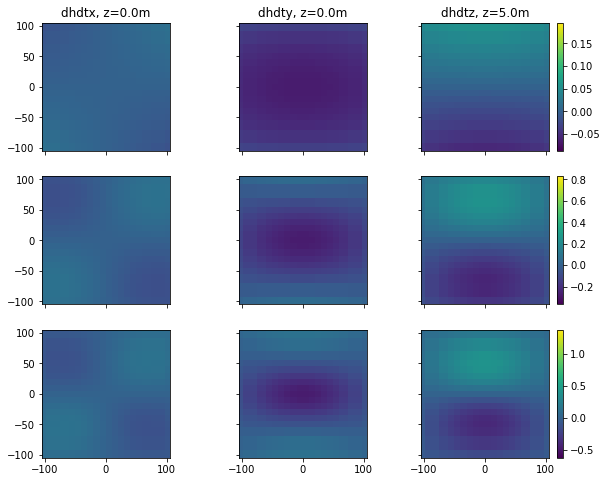

In [39]:
ti = time_inds[2]
print(f"{simh.times[ti]*1e3:1.0e} ms")
plot_field_time(ti, "dhdt", fieldsh);

1e+00 ms


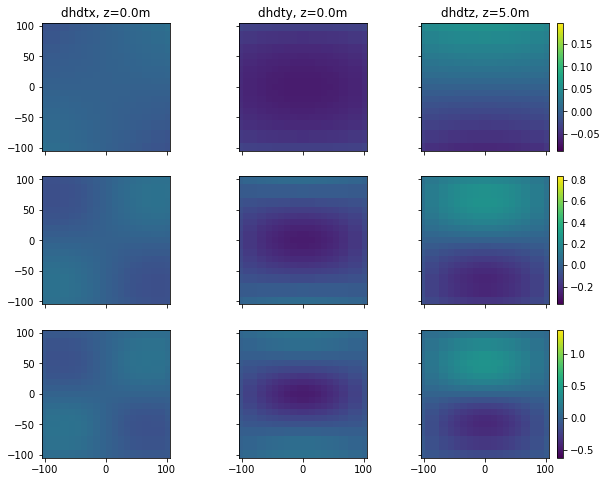

In [40]:
ti = time_inds[2]
print(f"{simh.times[ti]*1e3:1.0e} ms")
plot_field_time(ti,"dhdt", fieldsj);

1e+00 ms


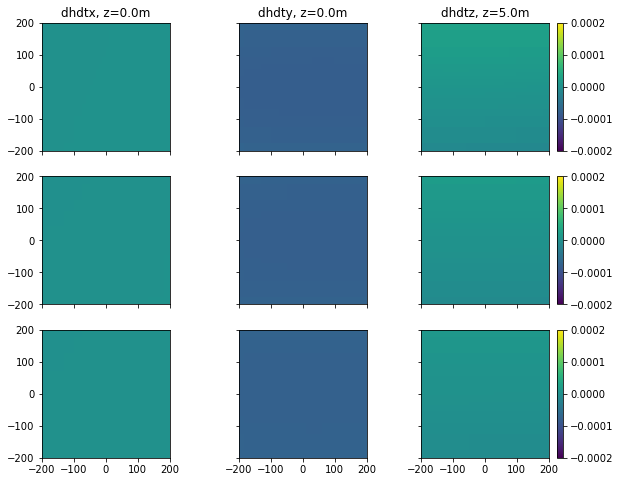

In [48]:
ti = time_inds[2]
print(f"{simh.times[ti]*1e3:1.0e} ms")
plot_field_time(ti, "dhdt", fieldsh, fieldsj, "difference", clim=2e-4*np.r_[-1, 1], xlim=200*np.r_[-1, 1]);

1e+00 ms


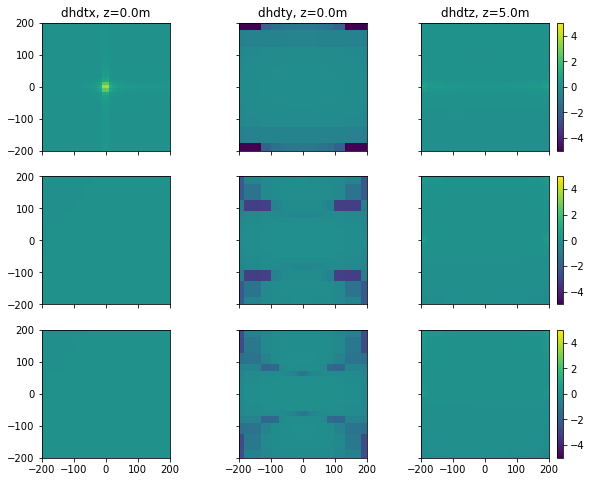

In [51]:
ti = time_inds[2]
print(f"{simh.times[ti]*1e3:1.0e} ms")
plot_field_time(ti, "dhdt", fieldsh, fieldsj, "percent", clim=5*np.r_[-1, 1], xlim=200*np.r_[-1, 1]);

1e+00 ms


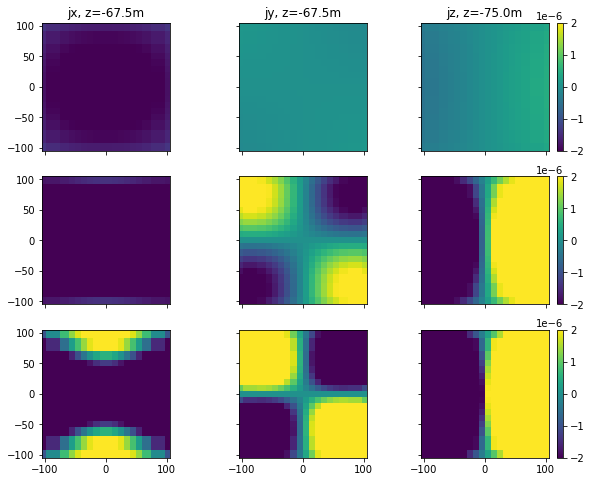

In [67]:
ti = time_inds[2]
print(f"{simh.times[ti]*1e3:1.0e} ms")
plot_field_time(ti, "j", fieldsh, ind=12, clim=2e-6*np.r_[-1, 1] );

1e+00 ms


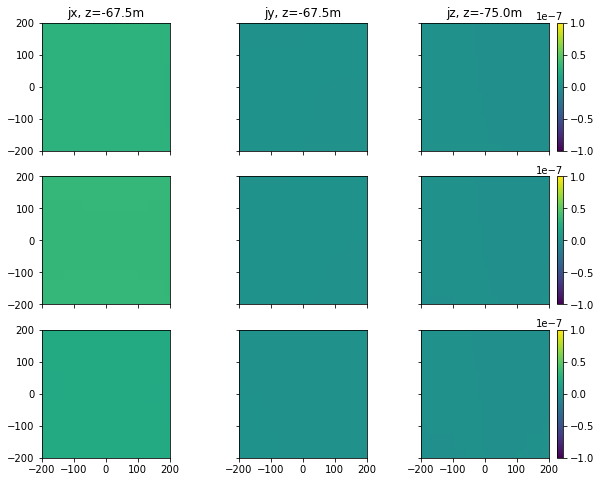

In [68]:
ti = time_inds[2]
print(f"{simh.times[ti]*1e3:1.0e} ms")
plot_field_time(ti, "j", fieldsh, fieldsj, "difference", xlim=200*np.r_[-1, 1], clim=1e-7*np.r_[-1, 1], ind=12);

1e+00 ms


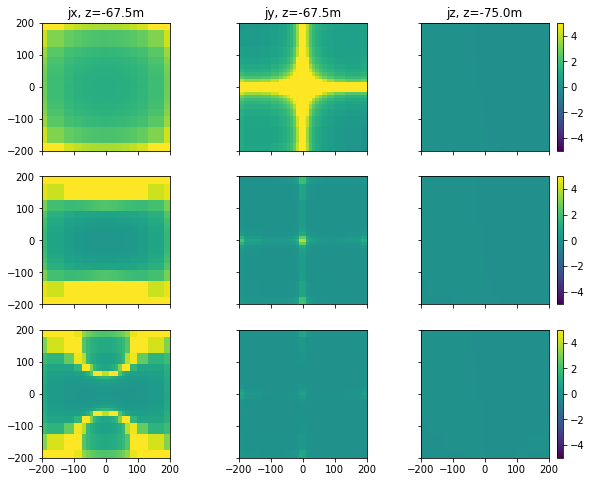

In [71]:
ti = time_inds[2]
print(f"{simh.times[ti]*1e3:1.0e} ms")
plot_field_time(ti, "j", fieldsh, fieldsj, "percent", xlim=200*np.r_[-1, 1], clim=5*np.r_[-1, 1], ind=12);

In [53]:
np.linalg.norm(fieldsj[key][:, "dhdt", tind])

205955.8219563624